In [40]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [41]:
mu = 8 # bits par symbole
K = 64 # Le nombre de sous-porteuses OFDM
CP = K//4  # La taille du préfixe cyclique (cyclic prefix) 25% du block
P = 8 # Le nombre de porteuses pilotes par bloc OFDM
pilotValue = 3+3j # La valeur connue pour chaque pilote transmet

In [42]:
allCarriers = np.arange(K)  # indices de toutes les sous-porteuses ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Les pilotes sont tous les (K/P)ièmes transporteurs.

# Pour faciliter l'estimation du canal, faisons en sorte que la dernière porteuse soit également pilote
if K%P != 1 :
    pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
    P = P+1

# les sous-porteuses de données sont toutes les sous-porteuses restantes
dataCarriers = np.delete(allCarriers, pilotCarriers)


print(f"Alors, on a {P} sous-porteuse pilote, ET {K-P} sous-porteuse de données.")

Alors, on a 9 sous-porteuse pilote, ET 55 sous-porteuse de données.


In [43]:
payloadBits_per_OFDM = len(dataCarriers)*mu  # nombre de bits de charge utile par symbole OFDM

In [44]:
mapping_table = {(0,0,0,0) : -3-3j,(0,0,0,1) : -3-1j,(0,0,1,0) : -3+3j,(0,0,1,1) : -3+1j,(0,1,0,0) : -1-3j,
(0,1,0,1) : -1-1j,(0,1,1,0) : -1+3j,(0,1,1,1) : -1+1j,(1,0,0,0) :  3-3j,(1,0,0,1) :  3-1j,(1,0,1,0) :  3+3j,
(1,0,1,1) :  3+1j,(1,1,0,0) :  1-3j,(1,1,0,1) :  1-1j,(1,1,1,0) :  1+3j,(1,1,1,1) :  1+1j }

demapping_table = {v : k for k, v in mapping_table.items()}

In [45]:
channelResponse = np.array([1, 0, 0.3+0.3j])  
H_exact = np.fft.fft(channelResponse, K)

SNRdb = 25  

le schema d'OFDM
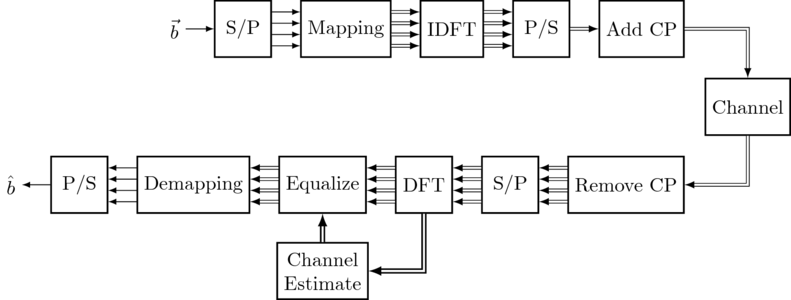

In [46]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM,)) # On génere les bits

In [47]:
# le convertisseur série-parallèle
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))

bits_SP = SP(bits)
print (bits_SP[:5,:])   # Afficher les cinq premier groupe

[[0 0 1 1]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [0 0 1 1]]


In [48]:
# le Mapping
def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])
QAM = Mapping(bits_SP)

In [49]:
# le symbole OFDM
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(QAM)

In [50]:
# le block IDFT (Inverse Discrete Fourier Transform)
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)

In [51]:
# On ajoute le préfixe cyclique
# le préfixe cyclique isole différents blocs OFDM les uns des autres lorsque le canal sans fil contient plusieurs chemins, 
#                                  c'est-à-dire qu'il est sélectif en fréquence.
def addCP(OFDM_time):
    cp = OFDM_time[-CP:] 
    return np.hstack([cp, OFDM_time])  
OFDM_withCP = addCP(OFDM_time)

In [52]:
# le cannal
def channel(signal):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    #print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)

In [53]:
def removeCP(signal):
    return signal[CP:(CP+K)]

OFDM_RX_noCP = removeCP(OFDM_RX)

In [54]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

OFDM_demod = DFT(OFDM_RX_noCP)

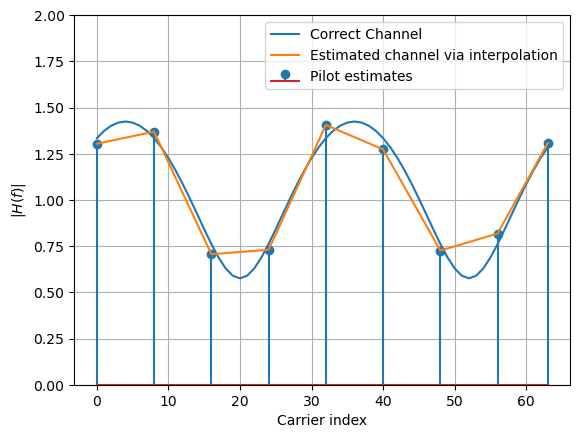

In [56]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True)
    plt.xlabel('Carrier index')
    plt.ylabel('$|H(f)|$')
    plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest


Hest = channelEstimate(OFDM_demod)

In [57]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

equalized_Hest = equalize(OFDM_demod, Hest)

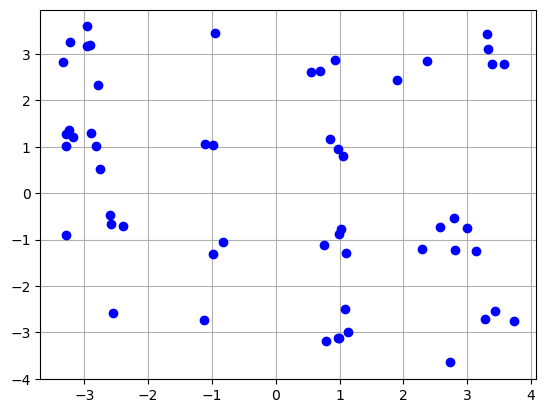

In [58]:
def get_payload(equalized):
    return equalized[dataCarriers]

QAM_est = get_payload(equalized_Hest)
plt.plot(QAM_est.real, QAM_est.imag, 'bo')
plt.grid(True)

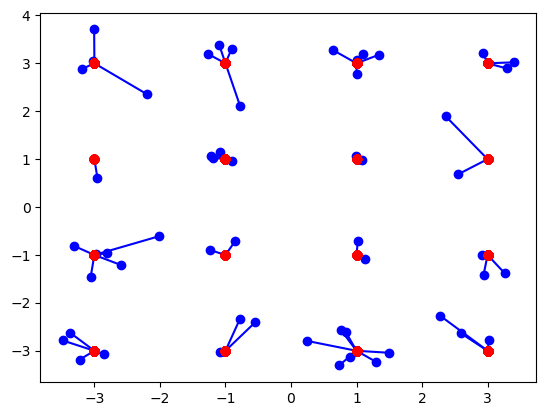

In [243]:
def Demapping(QAM):
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculater la distance entre tout point Rx par rapport tout point de symbole
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # pour chaque élément en QAM, choisir l'indice en constellation
    #            qui appartient au point de constellation le plus proche
    const_index = dists.argmin(axis=1)
    
    # récupérer le vrai point de constellation
    hardDecision = constellation[const_index]
    
    # transformer le point de constellation en groupes de bits
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

PS_est, Decision = Demapping(QAM_est)
for qam, hard in zip(QAM_est, Decision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(Decision.real, Decision.imag, 'ro')

In [244]:
def PS(bits):
    return bits.reshape((-1,))
bits_est = PS(PS_est)

In [245]:
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

Obtained Bit error rate:  0.004545454545454545
